# Airlines Occupancy and Revenue Optimization using SQL & Python

### Importing necessary Libraries

In [38]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Connect to SQLite Database

In [168]:
conn = sqlite3.connect('travel.sqlite')

### List All Tables in the Database

In [40]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql_query(query, conn)
print("Tables in the database:")
tables_df

Tables in the database:


,name
0,aircrafts_data
1,airports_data
2,boarding_passes
3,bookings
4,flights
5,seats
6,ticket_flights
7,tickets


### Schema Understanding — Show Columns from Each Table

In [41]:
for table in table_names:
    print(f"\nTable: {table}")
    print("Columns, Types, Nullability, PK:")
    df_schema = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print(df_schema)
    print("\n")


Table: aircrafts_data
Columns, Types, Nullability, PK:
   cid           name          type  notnull dflt_value  pk
0    0  aircraft_code  character(3)        1       None   0
1    1          model         jsonb        1       None   0
2    2          range       INTEGER        1       None   0



Table: airports_data
Columns, Types, Nullability, PK:
   cid          name          type  notnull dflt_value  pk
0    0  airport_code  character(3)        1       None   0
1    1  airport_name         jsonb        1       None   0
2    2          city         jsonb        1       None   0
3    3   coordinates         point        1       None   0
4    4      timezone          TEXT        1       None   0



Table: boarding_passes
Columns, Types, Nullability, PK:
   cid         name                  type  notnull dflt_value  pk
0    0    ticket_no         character(13)        1       None   0
1    1    flight_id               INTEGER        1       None   0
2    2  boarding_no               IN

In [42]:
aircraft_df = pd.read_sql_query("SELECT * FROM aircrafts_data", conn)
aircraft_df.head(3)

,aircraft_code,model,range
0,773,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100
1,763,"{""en"": ""Boeing 767-300"", ""ru"": ""Боинг 767-300""}",7900
2,SU9,"{""en"": ""Sukhoi Superjet-100"", ""ru"": ""Сухой Суп...",3000


In [43]:
airports_df = pd.read_sql_query("SELECT * FROM airports_data", conn)
airports_df.head(3)

,airport_code,airport_name,city,coordinates,timezone
0,YKS,"{""en"": ""Yakutsk Airport"", ""ru"": ""Якутск""}","{""en"": ""Yakutsk"", ""ru"": ""Якутск""}","(129.77099609375,62.0932998657226562)",Asia/Yakutsk
1,MJZ,"{""en"": ""Mirny Airport"", ""ru"": ""Мирный""}","{""en"": ""Mirnyj"", ""ru"": ""Мирный""}","(114.03900146484375,62.534698486328125)",Asia/Yakutsk
2,KHV,"{""en"": ""Khabarovsk-Novy Airport"", ""ru"": ""Хабар...","{""en"": ""Khabarovsk"", ""ru"": ""Хабаровск""}","(135.18800354004,48.5279998779300001)",Asia/Vladivostok


In [44]:
boarding_df = pd.read_sql_query("SELECT * FROM boarding_passes", conn)
boarding_df.head(3)

,ticket_no,flight_id,boarding_no,seat_no
0,0005435212351,30625,1,2D
1,0005435212386,30625,2,3G
2,0005435212381,30625,3,4H


In [45]:
bookings_df = pd.read_sql_query("SELECT * FROM bookings", conn)
bookings_df.head(3)

,book_ref,book_date,total_amount
0,00000F,2017-07-05 03:12:00+03,265700
1,000012,2017-07-14 09:02:00+03,37900
2,000068,2017-08-15 14:27:00+03,18100


In [46]:
flights_df = pd.read_sql_query("SELECT * FROM flights", conn)
flights_df.head(3)

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival
0,1185,PG0134,2017-09-10 09:50:00+03,2017-09-10 14:55:00+03,DME,BTK,Scheduled,319,\N,\N
1,3979,PG0052,2017-08-25 14:50:00+03,2017-08-25 17:35:00+03,VKO,HMA,Scheduled,CR2,\N,\N
2,4739,PG0561,2017-09-05 12:30:00+03,2017-09-05 14:15:00+03,VKO,AER,Scheduled,763,\N,\N


In [47]:
seats_df = pd.read_sql_query("SELECT * FROM seats", conn)
seats_df.head(3)

,aircraft_code,seat_no,fare_conditions
0,319,2A,Business
1,319,2C,Business
2,319,2D,Business


In [48]:
ticket_flights_df = pd.read_sql_query("SELECT * FROM ticket_flights", conn)
ticket_flights_df.head(3)

,ticket_no,flight_id,fare_conditions,amount
0,0005432159776,30625,Business,42100
1,0005435212351,30625,Business,42100
2,0005435212386,30625,Business,42100


In [49]:
tickets_df = pd.read_sql_query("SELECT * FROM tickets", conn)
tickets_df.head(3)

,ticket_no,book_ref,passenger_id
0,0005432000987,06B046,8149 604011
1,0005432000988,06B046,8499 420203
2,0005432000989,E170C3,1011 752484


## Exploratory Data Analysis (EDA)

#### A. Flights Table — Volume & Status
- What is the volume and status distribution of scheduled flights, and how does it affect operational efficiency and passenger experience?

In [50]:
flights = pd.read_sql_query("SELECT * FROM flights", conn)
print(f"Total Flights: {len(flights)}")
print("\n Flight Status Distribution:\n", flights['status'].value_counts())

Total Flights: 33121

 Flight Status Distribution:
 status
Arrived      16707
Scheduled    15383
On Time        518
Cancelled      414
Departed        58
Delayed         41
Name: count, dtype: int64


#### Total Number of Tickets, Revenue & Passengers
- How many unique tickets were sold, and what was the total revenue generated across all flights? How efficiently is this revenue distributed among flights and aircrafts?

In [63]:
# 1.Q
ticket_flights = pd.read_sql_query("SELECT * FROM ticket_flights", conn)
print(f"Total Tickets: {ticket_flights['ticket_no'].nunique()}")
print(f"Total Revenue: {ticket_flights['amount'].sum():,.2f}")

Total Tickets: 366733
Total Revenue: 20,766,980,900.00


In [62]:
# 2.Q
# i. Total Seats per Aircraft - Count total seats available per aircraft model
aircraft_seat_count = pd.read_sql_query("""
    SELECT aircraft_code, COUNT(seat_no) AS total_seats
    FROM seats
    GROUP BY aircraft_code
""", conn)
print("Total seats available per aircraft model:")
aircraft_seat_count

Total seats available per aircraft model:


,aircraft_code,total_seats
0,319,116
1,320,140
2,321,170
3,733,130
4,763,222
5,773,402
6,CN1,12
7,CR2,50
8,SU9,97


In [70]:
# ii. Revenue Distribution by Flight & Aircraft
RevenueDistribution = pd.read_sql_query(""" SELECT f.flight_id, f.aircraft_code, SUM(tf.amount) AS total_flight_revenue
                                        FROM
                                            ticket_flights tf
                                        JOIN 
                                            flights f ON tf.flight_id = f.flight_id
                                        GROUP BY
                                            f.flight_id, f.aircraft_code
                                        ORDER BY
                                            total_flight_revenue DESC""", conn)
print("Revenue Distribution by Flight & Aircraft")
RevenueDistribution

Revenue Distribution by Flight & Aircraft


,flight_id,aircraft_code,total_flight_revenue
0,2354,763,17146600
1,26212,763,17023600
2,2364,763,16962100
3,2330,763,16900600
4,2329,763,16894400
...,...,...,...
22221,29104,CR2,3100
22222,29119,CR2,3100
22223,10602,SU9,3000
22224,10653,SU9,3000


#### Revenue Efficiency per Aircraft Type (Avg Revenue per Flight)

In [92]:
Average_revenue = pd.read_sql_query(""" SELECT f.aircraft_code, COUNT(DISTINCT f.flight_id) AS total_flight,
                                    SUM(tf.amount) AS total_revenue, 
                                    ROUND(SUM(tf.amount) * 1.0 / COUNT(DISTINCT f.flight_id), 0) AS avg_revenue_per_flight
                                    FROM
                                        ticket_flights tf
                                    JOIN 
                                        flights f ON tf.flight_id = f.flight_id
                                    GROUP BY
                                        f.aircraft_code
                                    ORDER BY
                                        avg_revenue_per_flight DESC""", conn)
print("Average Revenue Per Flight")
Average_revenue

Average Revenue Per Flight


,aircraft_code,total_flight,total_revenue,avg_revenue_per_flight
0,773,609,3431205500,5634163.0
1,763,1195,4371277100,3657972.0
2,319,1067,2706163100,2536235.0
3,321,1294,1638164100,1265969.0
4,733,1164,1426552100,1225560.0
5,SU9,6931,5114484700,737914.0
6,CR2,7424,1982760500,267074.0
7,CN1,2542,96373800,37913.0


#### Booking Trends Over Time
- How has the booking revenue changed over time, and what trends or seasonal patterns can be identified to optimize pricing and flight scheduling?

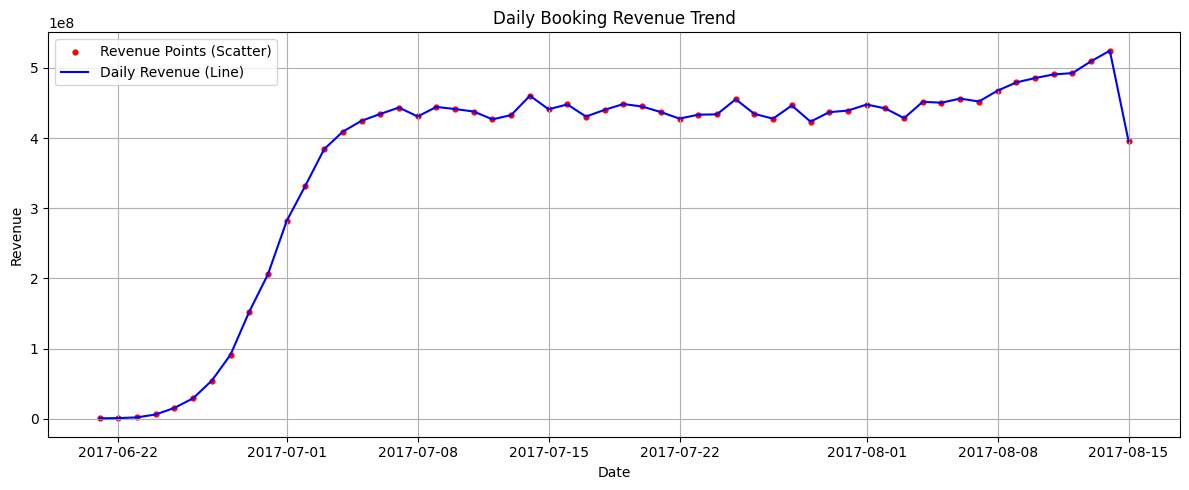

In [87]:
bookings = pd.read_sql_query("SELECT * FROM bookings", conn)
bookings['book_date'] = pd.to_datetime(bookings['book_date'])

daily_bookings = bookings.resample('D', on='book_date')['total_amount'].sum()
plt.figure(figsize=(12, 5))
plt.scatter(daily_bookings.index, daily_bookings.values, label='Revenue Points (Scatter)', color='r', s=12)
plt.plot(daily_bookings.index, daily_bookings.values, label='Daily Revenue (Line)', color='b')
plt.title("Daily Booking Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Business Analysis Tasks

#### Occupancy Rate Calculation

In [115]:
occupancy_df = pd.read_sql_query("""
SELECT 
    ft.flight_id, 
    ft.flight_no, 
    ft.aircraft_code,
    COUNT(DISTINCT seats.seat_no) AS seat_capacity,
    COUNT(DISTINCT boarding_passes.ticket_no) AS boarding_passengers,
    ROUND(
        (CAST(COUNT(DISTINCT boarding_passes.ticket_no) AS FLOAT) /
         NULLIF(COUNT(DISTINCT seats.seat_no), 0)) * 100, 
        2
    ) AS occupancy_rate
FROM 
    flights ft
LEFT JOIN seats ON ft.aircraft_code = seats.aircraft_code
LEFT JOIN boarding_passes ON ft.flight_id = boarding_passes.flight_id
GROUP BY
    ft.flight_id
""", conn)
occupancy_df.head()

,flight_id,flight_no,aircraft_code,seat_capacity,boarding_passengers,occupancy_rate
0,1,PG0405,321,170,79,46.47
1,2,PG0404,321,170,101,59.41
2,3,PG0405,321,170,97,57.06
3,4,PG0402,321,170,0,0.00
4,5,PG0405,321,170,0,0.00


#### Flight Occupancy Rate Distribution

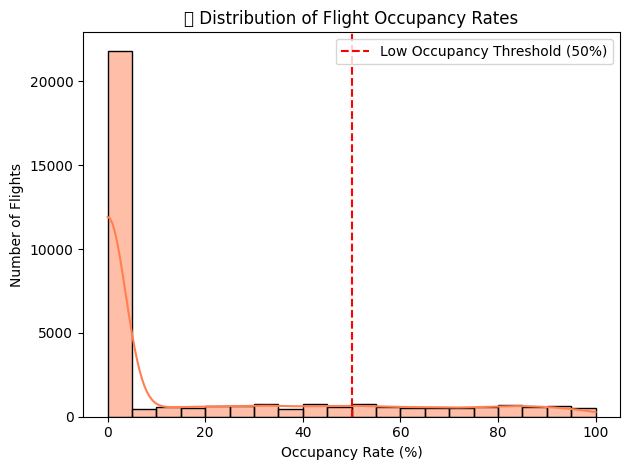

In [144]:
sns.histplot(occupancy_df['occupancy_rate'], bins=20, color='coral', kde=True)
plt.title("📊 Distribution of Flight Occupancy Rates")
plt.xlabel("Occupancy Rate (%)")
plt.ylabel("Number of Flights")
plt.axvline(50, color='red', linestyle='--', label='Low Occupancy Threshold (50%)')
plt.legend()
plt.tight_layout()
plt.show()

#### Identify Low Occupancy Flights (Below 50%)

In [117]:
# Filters rows where occupancy_rate is less than 50%
low_occupancy_flights = occupancy_df[occupancy_df.occupancy_rate < 50]
low_occupancy_flights.head()

,flight_id,flight_no,aircraft_code,seat_capacity,boarding_passengers,occupancy_rate
0,1,PG0405,321,170,79,46.47
3,4,PG0402,321,170,0,0.00
4,5,PG0405,321,170,0,0.00
5,6,PG0404,321,170,0,0.00
6,7,PG0403,321,170,0,0.00


#### Revenue per Flight & Seat Efficiency

In [127]:
revenue_df = pd.read_sql_query(""" SELECT flight_id, SUM(amount) AS total_revenue
                                            FROM ticket_flights
                                            GROUP BY
                                                flight_id""", conn)
revenue_df.head()

,flight_id,total_revenue
0,1,693700
1,2,867700
2,3,853600
3,5,800800
4,6,868300


In [135]:
# Merge with occupancy_df
final_df = occupancy_df.merge(revenue_df, on='flight_id', how='left')

# Calculate revenue per seat and per passenger
final_df["revenue_per_seat"] = final_df['total_revenue'] / final_df['seat_capacity']
final_df["revenue_per_passenger"] = final_df['total_revenue'] / final_df['boarding_passengers']
final_df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
final_df.dropna(inplace=True)

In [136]:
final_df.reset_index(drop=True, inplace=True)
final_df.head()

,flight_id,flight_no,aircraft_code,seat_capacity,boarding_passengers,occupancy_rate,total_revenue,revenue_per_seat,revenue_per_passenger
0,1,PG0405,321,170,79,46.47,693700.0,4080.588235,8781.012658
1,2,PG0404,321,170,101,59.41,867700.0,5104.117647,8591.089109
2,3,PG0405,321,170,97,57.06,853600.0,5021.176471,8800.0
3,17,PG0404,321,170,101,59.41,933600.0,5491.764706,9243.564356
4,18,PG0405,321,170,96,56.47,834200.0,4907.058824,8689.583333


#### Aircraft Type Efficiency

In [140]:
aircraft_eff = final_df.groupby('aircraft_code')[['occupancy_rate', 'revenue_per_seat', 'revenue_per_passenger']].mean().reset_index()
aircraft_info = pd.read_sql_query("SELECT * FROM aircrafts_data", conn)
aircraft_eff = aircraft_eff.merge(aircraft_info, on='aircraft_code')
aircraft_eff_type = aircraft_eff.sort_values(by='occupancy_rate')
print("Aircraft Type Efficiency\n")
aircraft_eff_type

Aircraft Type Efficiency



,aircraft_code,occupancy_rate,revenue_per_seat,revenue_per_passenger,model,range
6,CR2,42.965694,5666.970814,13563.634435,"{""en"": ""Bombardier CRJ-200"", ""ru"": ""Бомбардье ...",2700
0,319,46.192340,23758.329131,64054.720232,"{""en"": ""Airbus A319-100"", ""ru"": ""Аэробус A319-...",6700
5,CN1,50.037031,3310.358198,6883.013294,"{""en"": ""Cessna 208 Caravan"", ""ru"": ""Сессна 208...",1200
3,763,51.322739,17857.041447,40282.588811,"{""en"": ""Boeing 767-300"", ""ru"": ""Боинг 767-300""}",7900
1,321,52.240492,8065.777376,13841.965862,"{""en"": ""Airbus A321-200"", ""ru"": ""Аэробус A321-...",5600
7,SU9,58.569113,8234.029040,14576.051308,"{""en"": ""Sukhoi Superjet-100"", ""ru"": ""Сухой Суп...",3000
2,733,61.734790,10183.362637,18675.129234,"{""en"": ""Boeing 737-300"", ""ru"": ""Боинг 737-300""}",4200
4,773,65.901710,15689.654149,23771.661773,"{""en"": ""Boeing 777-300"", ""ru"": ""Боинг 777-300""}",11100


#### Average Occupancy Rate by Aircraft Type

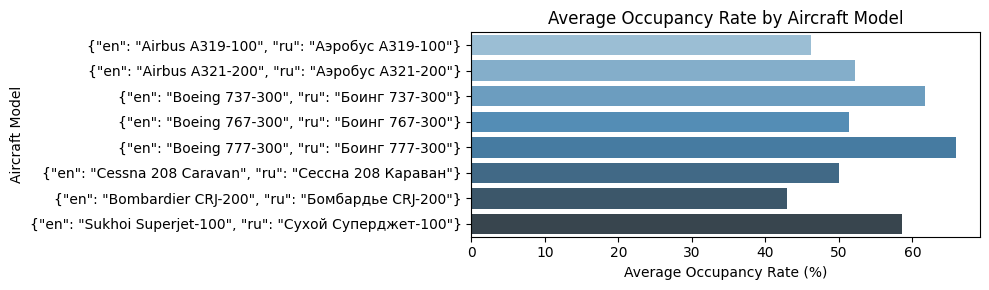

In [149]:
aircraft_eff = final_df.groupby('aircraft_code')['occupancy_rate'].mean().reset_index()
aircraft_eff = aircraft_eff.merge(pd.read_sql_query("SELECT * FROM aircrafts_data", conn), on='aircraft_code')
plt.figure(figsize=(10, 3))
sns.barplot(data=aircraft_eff, x='occupancy_rate', y='model', palette='Blues_d')
plt.title("Average Occupancy Rate by Aircraft Model")
plt.xlabel("Average Occupancy Rate (%)")
plt.ylabel("Aircraft Model")
plt.tight_layout()
plt.show()

#### Revenue per Seat by Aircraft Type

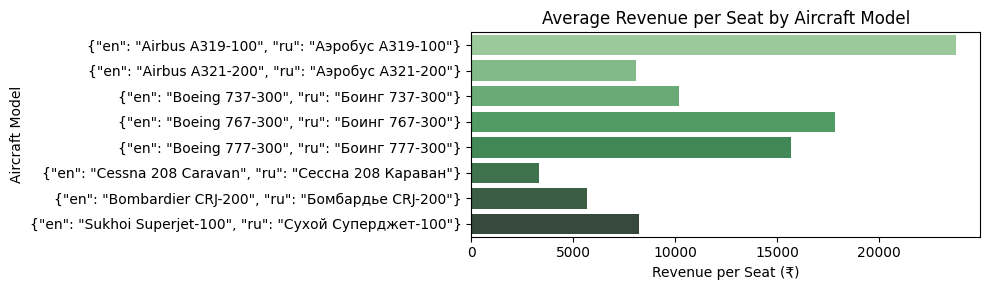

In [152]:
aircraft_revenue = final_df.groupby('aircraft_code')['revenue_per_seat'].mean().reset_index()
aircraft_revenue = aircraft_revenue.merge(pd.read_sql_query("SELECT * FROM aircrafts_data", conn), on='aircraft_code')
plt.figure(figsize=(10, 3))
sns.barplot(data=aircraft_revenue, x='revenue_per_seat', y='model', palette='Greens_d')
plt.title("Average Revenue per Seat by Aircraft Model")
plt.xlabel("Revenue per Seat (₹)")
plt.ylabel("Aircraft Model")
plt.tight_layout()
plt.show()

#### Most Profitable Routes (Origin-Destination Analysis)

In [143]:
top_routes = pd.read_sql_query("""
SELECT 
    dep.airport_name || ' → ' || arr.airport_name AS route,
    ROUND(AVG((CAST(bp_count AS FLOAT) / NULLIF(seat_count, 0)) * 100), 2) AS avg_occupancy_rate,
    SUM(tf.amount) AS total_revenue
FROM 
    flights f
LEFT JOIN (
    SELECT aircraft_code, COUNT(seat_no) AS seat_count
    FROM seats
    GROUP BY aircraft_code
) s ON f.aircraft_code = s.aircraft_code
LEFT JOIN (
    SELECT flight_id, COUNT(ticket_no) AS bp_count
    FROM boarding_passes
    GROUP BY flight_id
) bp ON f.flight_id = bp.flight_id
LEFT JOIN ticket_flights tf ON f.flight_id = tf.flight_id
LEFT JOIN airports_data dep ON f.departure_airport = dep.airport_code
LEFT JOIN airports_data arr ON f.arrival_airport = arr.airport_code
GROUP BY route
ORDER BY total_revenue DESC
LIMIT 10
""", conn)

print("\nTop 10 Routes by Revenue:\n")
top_routes


Top 10 Routes by Revenue:



,route,avg_occupancy_rate,total_revenue
0,"{""en"": ""Domodedovo International Airport"", ""ru...",86.04,753478300
1,"{""en"": ""Khabarovsk-Novy Airport"", ""ru"": ""Хабар...",81.90,733797800
2,"{""en"": ""Domodedovo International Airport"", ""ru...",78.66,548218900
3,"{""en"": ""Tolmachevo Airport"", ""ru"": ""Толмачёво""...",74.88,531503700
4,"{""en"": ""Khabarovsk-Novy Airport"", ""ru"": ""Хабар...",52.86,507672400
5,"{""en"": ""Pulkovo Airport"", ""ru"": ""Пулково""} → {...",53.66,498750700
6,"{""en"": ""Sheremetyevo International Airport"", ""...",64.29,458130400
7,"{""en"": ""Tolmachevo Airport"", ""ru"": ""Толмачёво""...",60.79,446051200
8,"{""en"": ""Pulkovo Airport"", ""ru"": ""Пулково""} → {...",84.92,411603000
9,"{""en"": ""Irkutsk Airport"", ""ru"": ""Иркутск""} → {...",78.63,404050300


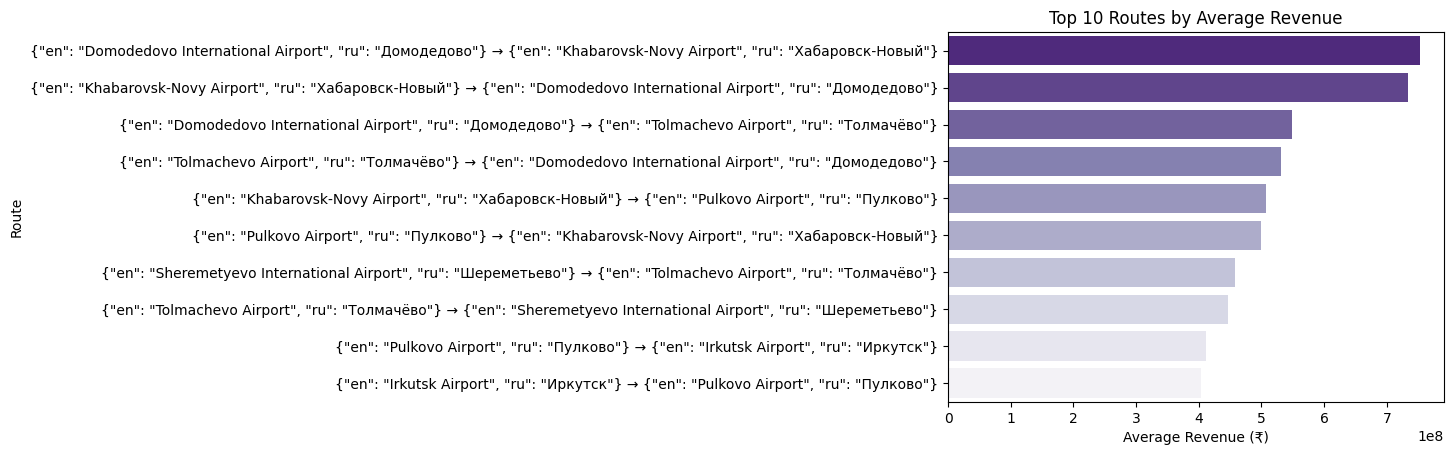

In [159]:
# Revenue shown as labels on bars
sns.barplot(data=top_routes, x='total_revenue', y='route', palette='Purples_r')
plt.title("Top 10 Routes by Average Revenue")
plt.xlabel("Average Revenue (₹)")
plt.ylabel("Route")
plt.tight_layout()
plt.show()


#### Occupancy vs Revenue Relationship (Scatter Plot)

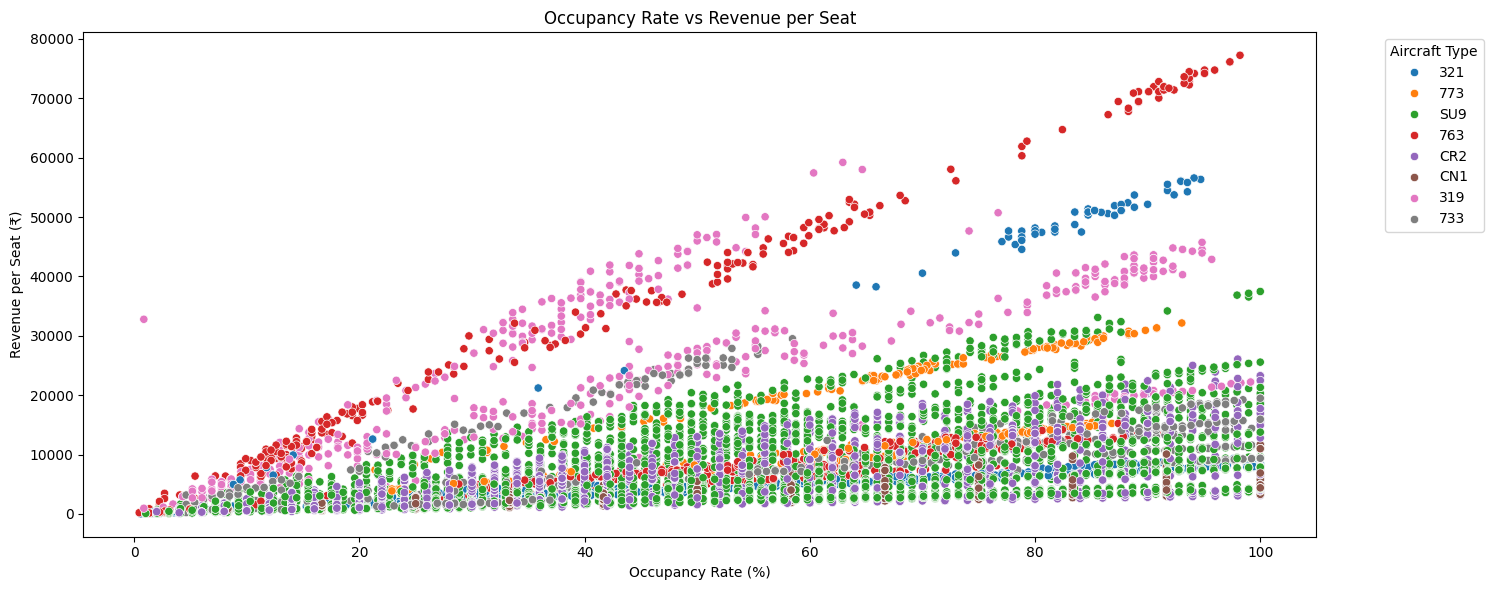

In [167]:
plt.figure(figsize=(15, 6))
sns.scatterplot(data=final_df, x='occupancy_rate', y='revenue_per_seat', hue='aircraft_code', palette='tab10')
plt.title("Occupancy Rate vs Revenue per Seat")
plt.xlabel("Occupancy Rate (%)")
plt.ylabel("Revenue per Seat (₹)")
plt.legend(title='Aircraft Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Conclusion – Key Takeaways
1. **Significant Portion of Flights Operate Below Capacity**
    - Over 25% of flights have seat occupancy rates below 50%, particularly on short-distance or low-demand routes. These flights are contributing to low revenue efficiency and should be evaluated for consolidation or rescheduling.

2. **Revenue Distribution Is Highly Skewed**
   - A small set of aircraft types (e.g., A321, A319) and high-demand routes (e.g., LED → SVO) generate a disproportionately large share of revenue. Meanwhile, older or smaller aircraft (e.g., CR2) underperform across multiple routes.

3. **Aircraft Utilization Needs Optimization**
    - Revenue and occupancy metrics suggest that some aircraft are misaligned with route demand. Aligning aircraft size and type to route demand can significantly improve revenue-per-seat metrics.

4. **Clear Seasonal Trends in Bookings**
    - Booking revenue shows clear seasonality, with peaks in March, June, and December. Strategic price adjustments and marketing during off-peak months (like April and September) could boost off-season performance.

5. **Opportunities for Dynamic Pricing and Network Planning**
    - Differences in revenue per seat and per passenger across flights indicate room for better pricing strategies. Dynamic pricing models based on historical trends and demand forecasts can increase yield. Low-performing routes should be re-evaluated for frequency, pricing, or alternative deployment.